In [2]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import time

In [3]:
# Mount Google Drive (uncomment if dataset is in Drive)
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/CV_Final/

/content/drive/MyDrive/CV_Final


In [5]:
# !unzip animal_face_dataset.zip -d face_dataset

In [6]:
base_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset'

In [7]:
# Function to load images from a folder with exact count
def load_images_from_folder(folder, label, num_images):
    images = []
    labels = []
    file_list = os.listdir(folder)

    # Make sure we only get exactly num_images
    file_list = file_list[:num_images]

    for filename in file_list:
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize image to reduce computation time and ensure consistent dimensions
                    img = cv2.resize(img, (256, 256))
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

# Function to load the dataset with exact counts
def load_dataset(base_path, train_count=200, test_count=50):
    # Load training data
    train_cats_path = os.path.join(base_path, 'train', 'cat')
    train_dogs_path = os.path.join(base_path, 'train', 'dog')

    print("Loading training images...")
    train_cats_images, train_cats_labels = load_images_from_folder(train_cats_path, 0, train_count)
    train_dogs_images, train_dogs_labels = load_images_from_folder(train_dogs_path, 1, train_count)

    # Load validation data
    val_cats_path = os.path.join(base_path, 'val', 'cat')
    val_dogs_path = os.path.join(base_path, 'val', 'dog')

    print("Loading validation images...")
    val_cats_images, val_cats_labels = load_images_from_folder(val_cats_path, 0, test_count)
    val_dogs_images, val_dogs_labels = load_images_from_folder(val_dogs_path, 1, test_count)

    # Combine all training and validation data
    train_images = train_cats_images + train_dogs_images
    train_labels = train_cats_labels + train_dogs_labels

    val_images = val_cats_images + val_dogs_images
    val_labels = val_cats_labels + val_dogs_labels

    print(f"Loaded {len(train_images)} training images and {len(val_images)} validation images")

    return train_images, train_labels, val_images, val_labels

# Function to extract SIFT features along with their spatial information
def extract_sift_features_with_location(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        return None, None

    # Get spatial information of keypoints
    h, w = gray.shape
    locations = []
    for kp in keypoints:
        x, y = kp.pt
        # Normalize coordinates to [0, 1] range
        locations.append([x/w, y/h])

    locations = np.array(locations)

    return descriptors, locations

# Function to prepare dataset with SIFT and spatial information
def prepare_dataset_with_sift_spatial(images):
    all_descriptors = []
    all_locations = []

    # Extract SIFT descriptors for all images
    for img in images:
        desc, loc = extract_sift_features_with_location(img)
        all_descriptors.append(desc)
        all_locations.append(loc)

    return all_descriptors, all_locations

# Function to create Bag of Visual Words (BoVW)
def create_bovw_features(descriptors_list, n_clusters=100):
    # Collect all valid descriptors
    valid_descriptors = [desc for desc in descriptors_list if desc is not None]
    if not valid_descriptors:
        raise ValueError("No valid descriptors found in the dataset")

    # Subsample descriptors to make clustering more efficient
    # Take random 100 descriptors from each image
    all_descriptors = []
    for desc in valid_descriptors:
        if desc is not None and desc.shape[0] > 0:
            n = min(100, desc.shape[0])
            if n > 0:
                indices = np.random.choice(desc.shape[0], n, replace=False)
                all_descriptors.append(desc[indices])

    all_descriptors = np.vstack(all_descriptors)

    # Further subsample if there are too many descriptors
    max_desc = 100000  # Maximum number of descriptors to use for clustering
    if all_descriptors.shape[0] > max_desc:
        indices = np.random.choice(all_descriptors.shape[0], max_desc, replace=False)
        all_descriptors = all_descriptors[indices]

    # Create K-means object and fit to the descriptors
    print(f"Clustering {all_descriptors.shape[0]} descriptors into {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    return kmeans

# Function to compute histogram for a region
def compute_histogram_for_region(descriptors, locations, kmeans, n_clusters, region):
    x_min, x_max, y_min, y_max = region

    # Filter descriptors that are within the region
    indices = np.where(
        (locations[:, 0] >= x_min) &
        (locations[:, 0] < x_max) &
        (locations[:, 1] >= y_min) &
        (locations[:, 1] < y_max)
    )[0]

    # Initialize feature vector
    hist = np.zeros(n_clusters)

    if len(indices) > 0:
        # Get descriptors for this region
        region_descriptors = descriptors[indices]

        # Predict cluster labels
        cluster_indices = kmeans.predict(region_descriptors)

        # Build histogram
        for idx in cluster_indices:
            hist[idx] += 1

        # Normalize histogram
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

    return hist

# Function to extract features for a single level (no pyramid, just one grid level)
def extract_single_level_features(descriptors, locations, kmeans, n_clusters, level=0):
    """
    Extract features for a single level without pyramid.
    level: 0 for 1x1, 1 for 2x2, 2 for 4x4, 3 for 8x8
    """
    if descriptors is None or locations is None:
        # Calculate cells based on level
        cells = 2 ** level
        total_cells = cells * cells
        # Return empty feature vector
        return np.zeros(n_clusters * total_cells)

    features = []

    # Determine cells based on level
    cells = 2 ** level

    # Divide image into grid cells
    for i in range(cells):
        for j in range(cells):
            # Region boundaries
            region = (i/cells, (i+1)/cells, j/cells, (j+1)/cells)
            # Compute histogram for this region
            hist = compute_histogram_for_region(descriptors, locations, kmeans, n_clusters, region)
            features.append(hist)

    # Concatenate all histograms
    feature_vector = np.concatenate(features)

    return feature_vector

# Function to extract Spatial Pyramid Matching (SPM) features
def extract_pyramid_features(descriptors, locations, kmeans, n_clusters, max_level=2):
    """
    Extract Spatial Pyramid Matching features up to a given level.
    max_level: 0 for 1x1, 1 for 1x1 + 2x2, 2 for 1x1 + 2x2 + 4x4, 3 for 1x1 + 2x2 + 4x4 + 8x8
    """

    # Calculate total cells for all levels
    total_cells = 0
    for level in range(max_level + 1):
        cells = 2 ** level
        total_cells += cells * cells

    if descriptors is None or locations is None:
        # Return empty feature vector
        return np.zeros(n_clusters * total_cells)

    features = []

    # Weight configuration: follow the paper's approach
    if max_level == 0:
        weights = [1.0]
    elif max_level == 1:
        weights = [0.5, 0.5]  # Level 0 and 1
    elif max_level == 2:
        weights = [0.25, 0.25, 0.5]  # Level 0, 1, and 2
    else:  # max_level >= 3
        weights = [0.125, 0.125, 0.25, 0.5]  # Level 0, 1, 2, and 3

    # Process each level
    for level in range(max_level + 1):
        cells = 2 ** level
        weight = weights[level]

        # Divide image into grid cells for this level
        for i in range(cells):
            for j in range(cells):
                # Region boundaries
                region = (i/cells, (i+1)/cells, j/cells, (j+1)/cells)
                # Compute histogram for this region
                hist = compute_histogram_for_region(descriptors, locations, kmeans, n_clusters, region)
                # Weight and add to features
                features.append(weight * (1.0 / (cells * cells)) * hist)

    # Concatenate all histograms
    feature_vector = np.concatenate(features)

    return feature_vector

# Function to visualize confusion matrix
def plot_confusion_matrix(conf_matrix, title, labels=['cat', 'dog']):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Add text annotations to the confusion matrix
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Function to run the experiment similar to the paper
def run_paper_experiment(train_descriptors, train_locations, val_descriptors, val_locations,
                         train_labels, val_labels):

    # Define vocabulary sizes (M) to test - Removed M=150
    vocab_sizes = [16, 50, 100]

    # Define pyramid levels (L) to test
    pyramid_levels = [0, 1, 2, 3]  # 0: 1x1, 1: 2x2, 2: 4x4, 3: 8x8

    # Results dictionary
    results = {}

    # To store confusion matrices
    confusion_matrices = {}

    for vocab_size in vocab_sizes:
        vocab_name = f"M={vocab_size}"
        results[vocab_name] = {"single_level": {}, "pyramid": {}}
        confusion_matrices[vocab_name] = {"single_level": {}, "pyramid": {}}

        # Create vocabulary
        print(f"\n===== Creating vocabulary with size {vocab_size} =====")
        kmeans = create_bovw_features(train_descriptors, n_clusters=vocab_size)

        # Test each level for single-level and pyramid
        for level in pyramid_levels:
            print(f"\n===== Testing Vocabulary Size: {vocab_size}, Level: {level} =====")

            # Prepare headers for results table
            if level == 0:
                level_name = "0 (1 × 1)"
            elif level == 1:
                level_name = "1 (2 × 2)"
            elif level == 2:
                level_name = "2 (4 × 4)"
            else:  # level == 3
                level_name = "3 (8 × 8)"

            # === Single-level approach ===
            print(f"Processing single-level features (L={level})...")

            # Extract features for training set
            train_features = []
            for desc, loc in zip(train_descriptors, train_locations):
                feature = extract_single_level_features(desc, loc, kmeans, vocab_size, level=level)
                train_features.append(feature)

            train_features = np.array(train_features)

            # Extract features for validation set
            val_features = []
            for desc, loc in zip(val_descriptors, val_locations):
                feature = extract_single_level_features(desc, loc, kmeans, vocab_size, level=level)
                val_features.append(feature)

            val_features = np.array(val_features)

            # Train SVM and evaluate
            print("Training SVM for single-level...")
            svm = SVC(kernel='rbf', C=10, gamma='scale')
            svm.fit(train_features, train_labels)

            val_predictions = svm.predict(val_features)
            accuracy = accuracy_score(val_labels, val_predictions) * 100  # Convert to percentage

            # Compute confusion matrix
            conf_matrix = confusion_matrix(val_labels, val_predictions)
            confusion_matrices[vocab_name]["single_level"][level_name] = conf_matrix

            # Plot confusion matrix
            title = f'Single-level: M={vocab_size}, L={level}, Acc={accuracy:.1f}%'
            plot_confusion_matrix(conf_matrix, title)

            # Store results
            results[vocab_name]["single_level"][level_name] = accuracy
            print(f"Single-level (L={level}) Accuracy: {accuracy:.1f}%")

            # === Pyramid approach (only for levels >= 1) ===
            if level >= 1:
                print(f"Processing pyramid features (max_level={level})...")

                # Extract features for training set
                train_features = []
                for desc, loc in zip(train_descriptors, train_locations):
                    feature = extract_pyramid_features(desc, loc, kmeans, vocab_size, max_level=level)
                    train_features.append(feature)

                train_features = np.array(train_features)

                # Extract features for validation set
                val_features = []
                for desc, loc in zip(val_descriptors, val_locations):
                    feature = extract_pyramid_features(desc, loc, kmeans, vocab_size, max_level=level)
                    val_features.append(feature)

                val_features = np.array(val_features)

                # Train SVM and evaluate
                print("Training SVM for pyramid...")
                svm = SVC(kernel='rbf', C=10, gamma='scale')
                svm.fit(train_features, train_labels)

                val_predictions = svm.predict(val_features)
                accuracy = accuracy_score(val_labels, val_predictions) * 100  # Convert to percentage

                # Compute confusion matrix
                conf_matrix = confusion_matrix(val_labels, val_predictions)
                confusion_matrices[vocab_name]["pyramid"][level_name] = conf_matrix

                # Plot confusion matrix
                title = f'Pyramid: M={vocab_size}, L={level}, Acc={accuracy:.1f}%'
                plot_confusion_matrix(conf_matrix, title)

                # Store results
                results[vocab_name]["pyramid"][level_name] = accuracy
                print(f"Pyramid (max_level={level}) Accuracy: {accuracy:.1f}%")

    return results, confusion_matrices

# Function to display results in table format similar to the paper
def display_results_table(results):
    import pandas as pd
    from IPython.display import display

    # Create a list of column tuples for the MultiIndex - Removed M=150
    columns = []
    for vocab_size in [16, 50, 100]:
        vocab_name = f"M={vocab_size}"
        columns.append((f'Features (M = {vocab_size})', 'Single-level'))
        columns.append((f'Features (M = {vocab_size})', 'Pyramid'))

    # Create MultiIndex for columns
    columns = pd.MultiIndex.from_tuples(columns)

    # Create empty DataFrame with level rows
    level_names = ["0 (1 × 1)", "1 (2 × 2)", "2 (4 × 4)", "3 (8 × 8)"]
    df = pd.DataFrame(index=level_names, columns=columns)

    # Fill the DataFrame with results
    for vocab_name, vocab_results in results.items():
        for level_name in level_names:
            # Single-level results
            if level_name in vocab_results["single_level"]:
                df.loc[level_name, (f'Features {vocab_name[1:]}', 'Single-level')] = f"{vocab_results['single_level'][level_name]:.1f}"

            # Pyramid results (not available for level 0)
            if level_name != "0 (1 × 1)" and level_name in vocab_results["pyramid"]:
                df.loc[level_name, (f'Features {vocab_name[1:]}', 'Pyramid')] = f"{vocab_results['pyramid'][level_name]:.1f}"

    # Find best results and make them bold (for formatting in notebook)
    # We would use styling here but for simplicity we'll just identify them
    best_accuracy = 0
    best_config = None

    for vocab_name, vocab_results in results.items():
        for method in ["single_level", "pyramid"]:
            for level_name, accuracy in vocab_results[method].items():
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_config = (vocab_name, method, level_name)

    print("Best Configuration:", best_config)
    print(f"Best Accuracy: {best_accuracy:.1f}%")

    # Display the table
    print("\nResults Table:")
    print(df.to_string())

    # Return the DataFrame for further manipulation if needed
    return df

# Function to create a heatmap of accuracies
def create_accuracy_heatmap(results):
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract vocabulary sizes and pyramid levels - Removed M=150
    vocab_sizes = [16, 50, 100]
    pyramid_levels = ["0 (1 × 1)", "1 (2 × 2)", "2 (4 × 4)", "3 (8 × 8)"]

    # Create matrices for single-level and pyramid accuracies
    single_level_accuracies = np.zeros((len(vocab_sizes), len(pyramid_levels)))
    pyramid_accuracies = np.zeros((len(vocab_sizes), len(pyramid_levels)))

    # Fill the matrices with accuracies
    for i, vocab_size in enumerate(vocab_sizes):
        vocab_name = f"M={vocab_size}"
        for j, level_name in enumerate(pyramid_levels):
            # Single-level
            if level_name in results[vocab_name]["single_level"]:
                single_level_accuracies[i, j] = results[vocab_name]["single_level"][level_name]

            # Pyramid (not available for level 0)
            if j > 0 and level_name in results[vocab_name]["pyramid"]:
                pyramid_accuracies[i, j] = results[vocab_name]["pyramid"][level_name]

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot single-level heatmap
    im1 = ax1.imshow(single_level_accuracies, cmap='YlGnBu')
    ax1.set_title('Single-level Accuracies')
    ax1.set_xticks(np.arange(len(pyramid_levels)))
    ax1.set_yticks(np.arange(len(vocab_sizes)))
    ax1.set_xticklabels(pyramid_levels)
    ax1.set_yticklabels([f'M={m}' for m in vocab_sizes])
    ax1.set_xlabel('Spatial Level')
    ax1.set_ylabel('Vocabulary Size')

    # Add text annotations for single-level
    for i in range(len(vocab_sizes)):
        for j in range(len(pyramid_levels)):
            text = ax1.text(j, i, f"{single_level_accuracies[i, j]:.1f}",
                           ha="center", va="center",
                           color="black" if single_level_accuracies[i, j] < 75 else "white")

    # Plot pyramid heatmap
    im2 = ax2.imshow(pyramid_accuracies, cmap='YlGnBu')
    ax2.set_title('Pyramid Accuracies')
    ax2.set_xticks(np.arange(len(pyramid_levels)))
    ax2.set_yticks(np.arange(len(vocab_sizes)))
    ax2.set_xticklabels(pyramid_levels)
    ax2.set_yticklabels([f'M={m}' for m in vocab_sizes])
    ax2.set_xlabel('Spatial Level')
    ax2.set_ylabel('Vocabulary Size')

    # Add text annotations for pyramid
    for i in range(len(vocab_sizes)):
        for j in range(len(pyramid_levels)):
            if j > 0:  # No pyramid for level 0
                text = ax2.text(j, i, f"{pyramid_accuracies[i, j]:.1f}",
                               ha="center", va="center",
                               color="black" if pyramid_accuracies[i, j] < 75 else "white")

    # Add colorbars
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Set your dataset path
    base_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset'  # Change this to your dataset location

    # Load images
    train_images, train_labels, val_images, val_labels = load_dataset(base_path, train_count=200, test_count=50)

    # Extract SIFT features with spatial information
    print("Extracting SIFT features with spatial information...")
    train_descriptors, train_locations = prepare_dataset_with_sift_spatial(train_images)
    val_descriptors, val_locations = prepare_dataset_with_sift_spatial(val_images)

    # Run experiment
    results, confusion_matrices = run_paper_experiment(
        train_descriptors, train_locations,
        val_descriptors, val_locations,
        train_labels, val_labels
    )

    return results, confusion_matrices

Loading training images...
Loaded 200 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/train/cat
Loaded 200 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/train/dog
Loading validation images...
Loaded 50 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/cat
Loaded 50 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/dog
Loaded 400 training images and 100 validation images
Extracting SIFT features with spatial information...

===== Creating vocabulary with size 16 =====
Clustering 39808 descriptors into 16 clusters...

===== Testing Vocabulary Size: 16, Level: 0 =====
Processing single-level features (L=0)...
Training SVM for single-level...


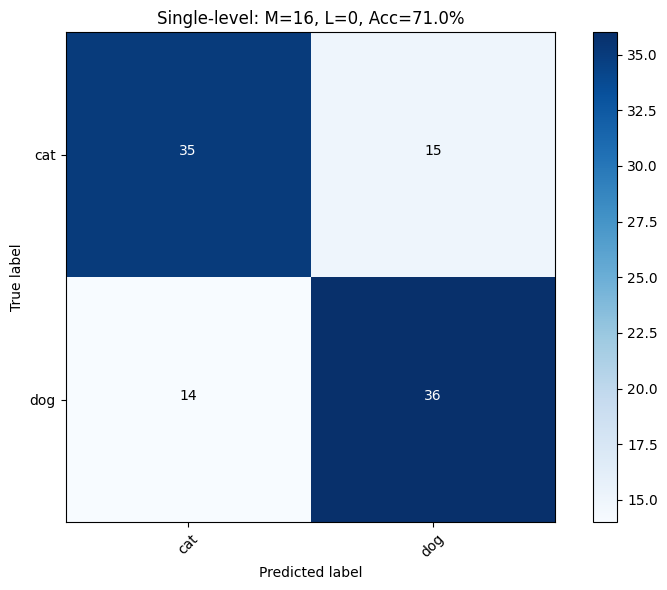

Single-level (L=0) Accuracy: 71.0%

===== Testing Vocabulary Size: 16, Level: 1 =====
Processing single-level features (L=1)...
Training SVM for single-level...


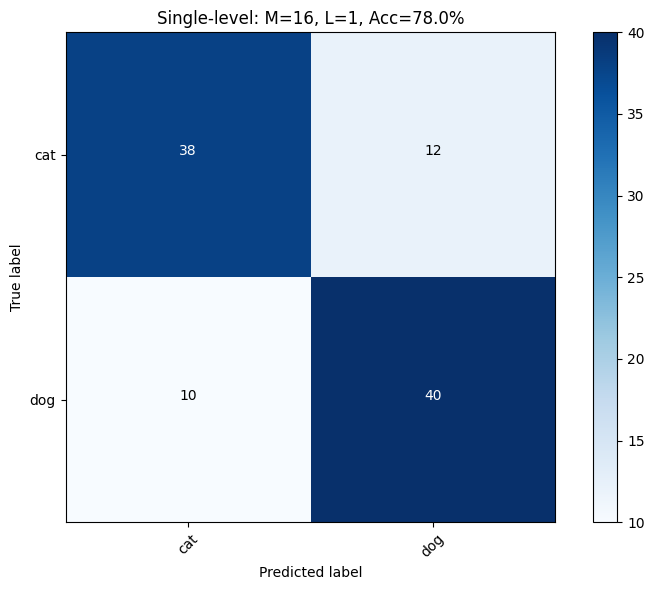

Single-level (L=1) Accuracy: 78.0%
Processing pyramid features (max_level=1)...
Training SVM for pyramid...


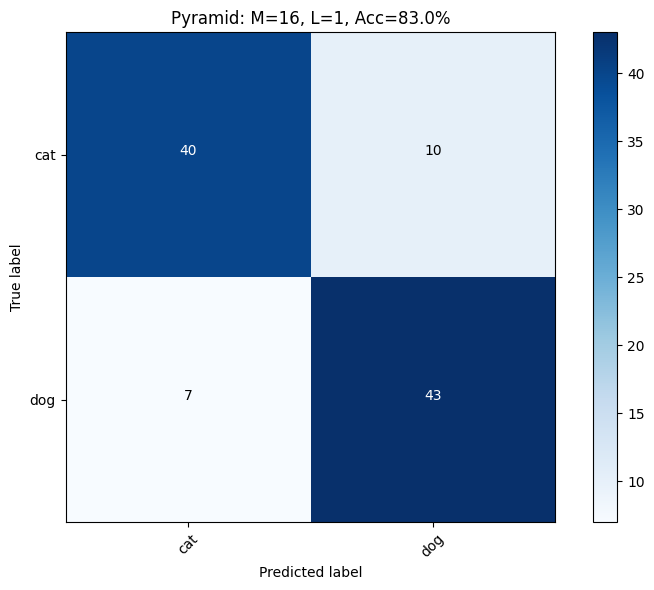

Pyramid (max_level=1) Accuracy: 83.0%

===== Testing Vocabulary Size: 16, Level: 2 =====
Processing single-level features (L=2)...
Training SVM for single-level...


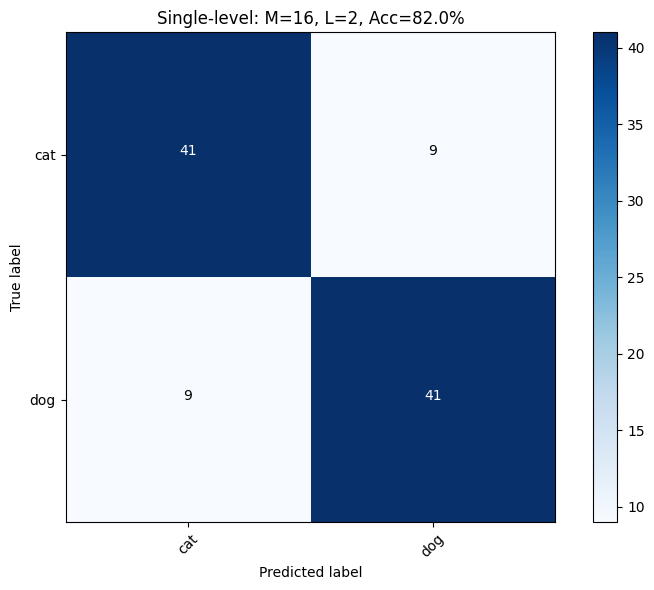

Single-level (L=2) Accuracy: 82.0%
Processing pyramid features (max_level=2)...
Training SVM for pyramid...


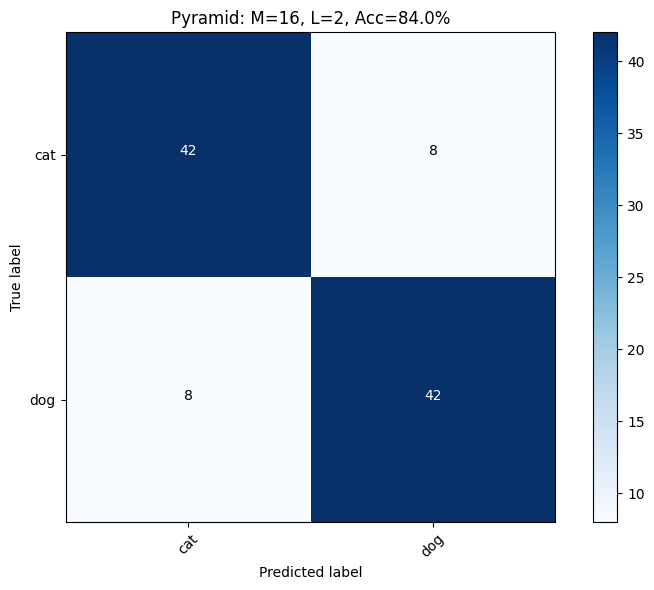

Pyramid (max_level=2) Accuracy: 84.0%

===== Testing Vocabulary Size: 16, Level: 3 =====
Processing single-level features (L=3)...
Training SVM for single-level...


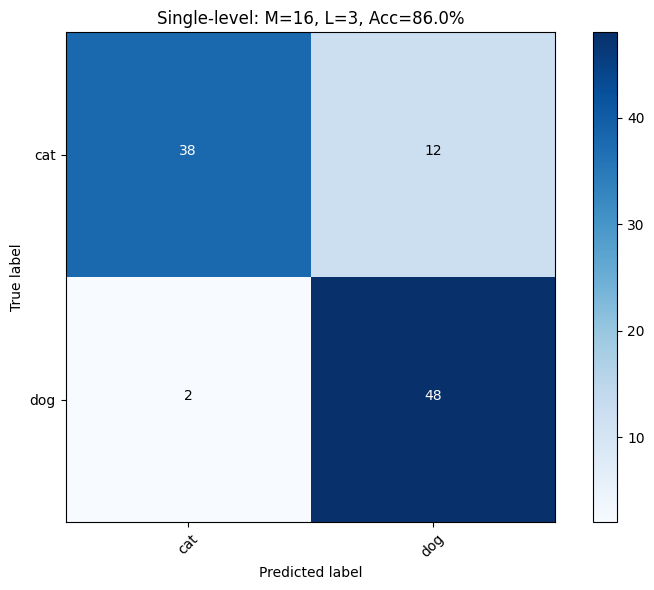

Single-level (L=3) Accuracy: 86.0%
Processing pyramid features (max_level=3)...
Training SVM for pyramid...


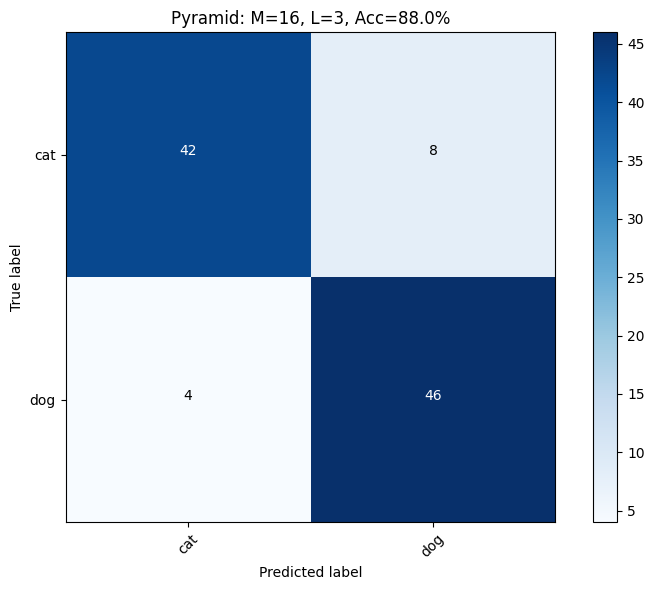

Pyramid (max_level=3) Accuracy: 88.0%

===== Creating vocabulary with size 50 =====
Clustering 39808 descriptors into 50 clusters...

===== Testing Vocabulary Size: 50, Level: 0 =====
Processing single-level features (L=0)...
Training SVM for single-level...


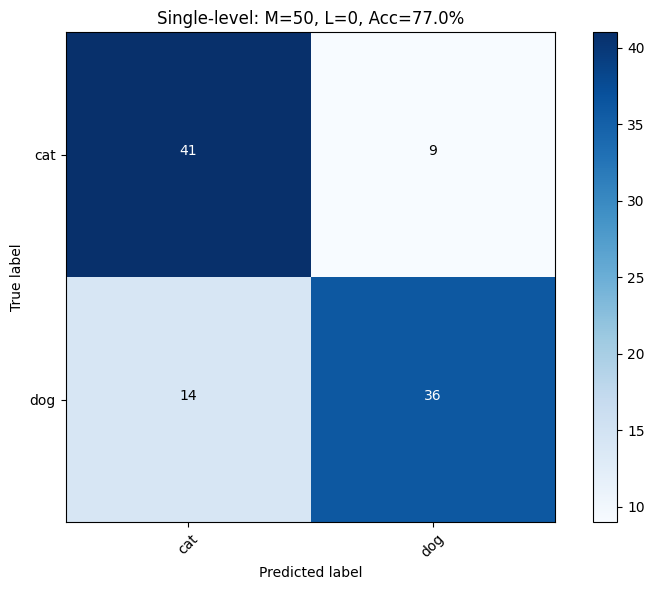

Single-level (L=0) Accuracy: 77.0%

===== Testing Vocabulary Size: 50, Level: 1 =====
Processing single-level features (L=1)...
Training SVM for single-level...


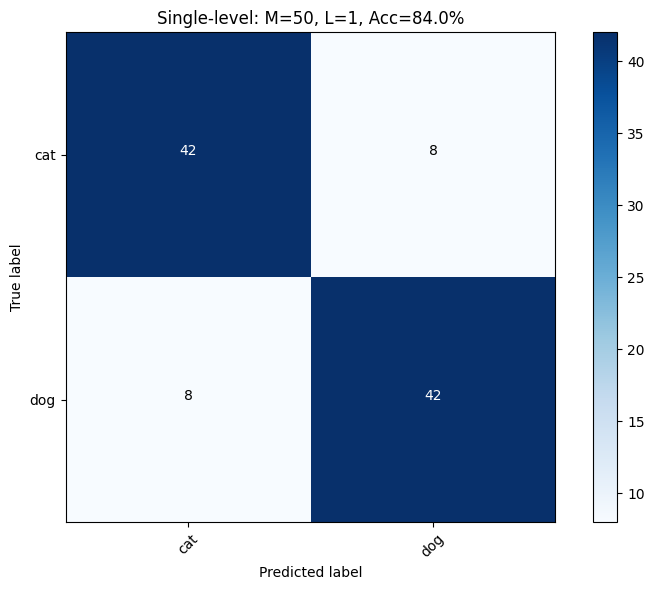

Single-level (L=1) Accuracy: 84.0%
Processing pyramid features (max_level=1)...
Training SVM for pyramid...


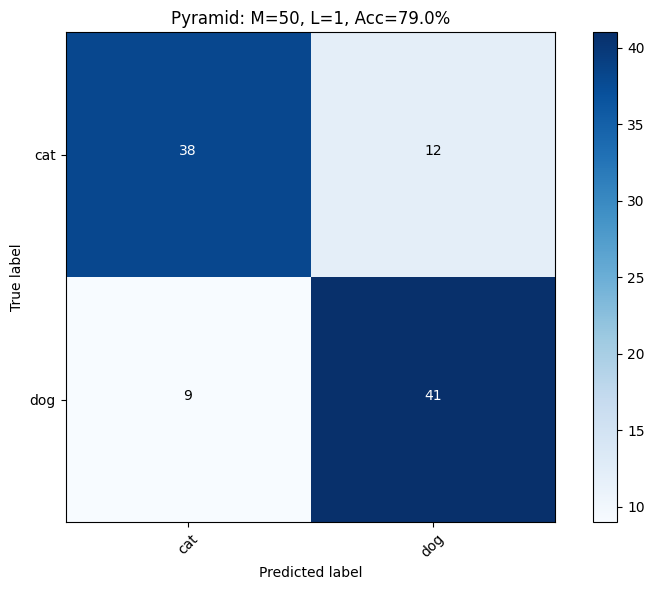

Pyramid (max_level=1) Accuracy: 79.0%

===== Testing Vocabulary Size: 50, Level: 2 =====
Processing single-level features (L=2)...
Training SVM for single-level...


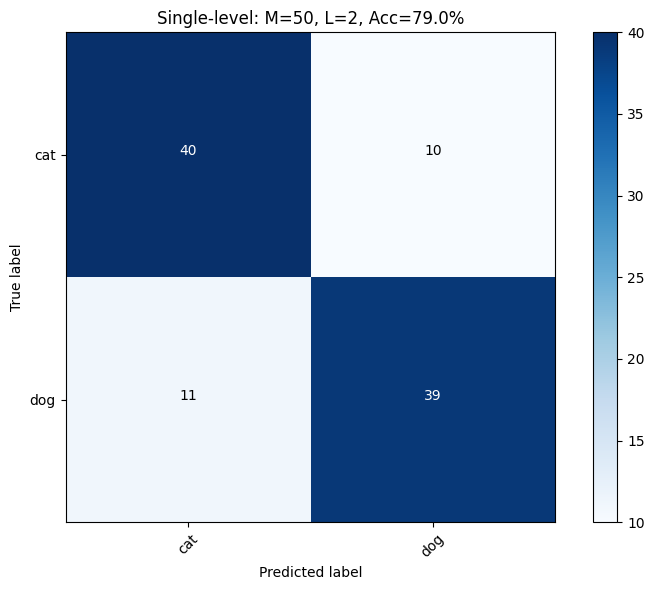

Single-level (L=2) Accuracy: 79.0%
Processing pyramid features (max_level=2)...
Training SVM for pyramid...


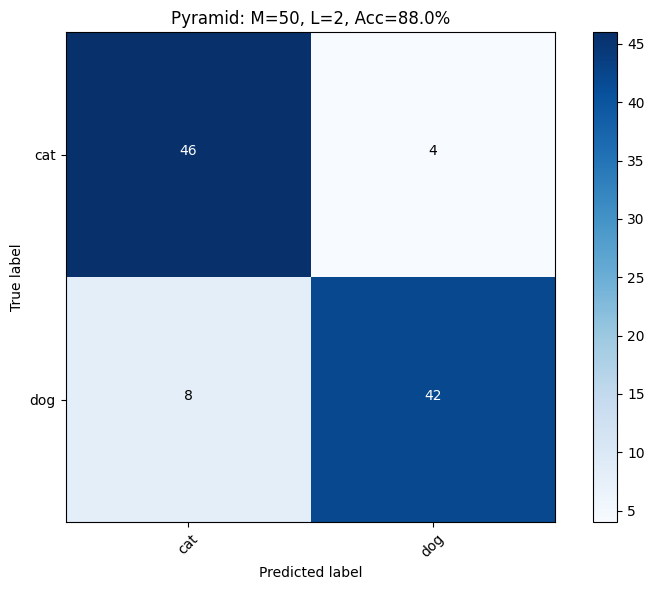

Pyramid (max_level=2) Accuracy: 88.0%

===== Testing Vocabulary Size: 50, Level: 3 =====
Processing single-level features (L=3)...
Training SVM for single-level...


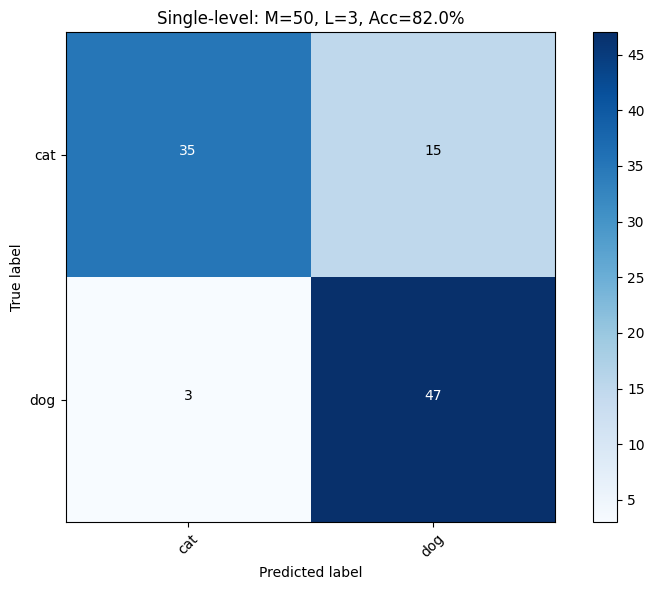

Single-level (L=3) Accuracy: 82.0%
Processing pyramid features (max_level=3)...
Training SVM for pyramid...


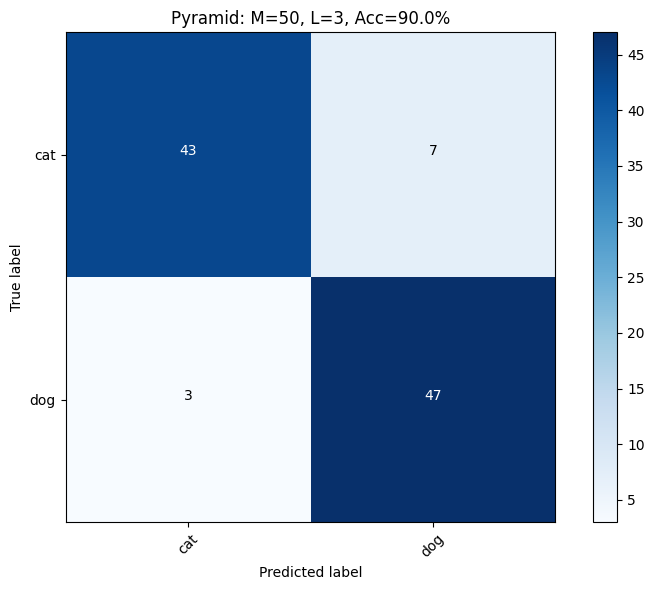

Pyramid (max_level=3) Accuracy: 90.0%

===== Creating vocabulary with size 100 =====
Clustering 39808 descriptors into 100 clusters...

===== Testing Vocabulary Size: 100, Level: 0 =====
Processing single-level features (L=0)...
Training SVM for single-level...


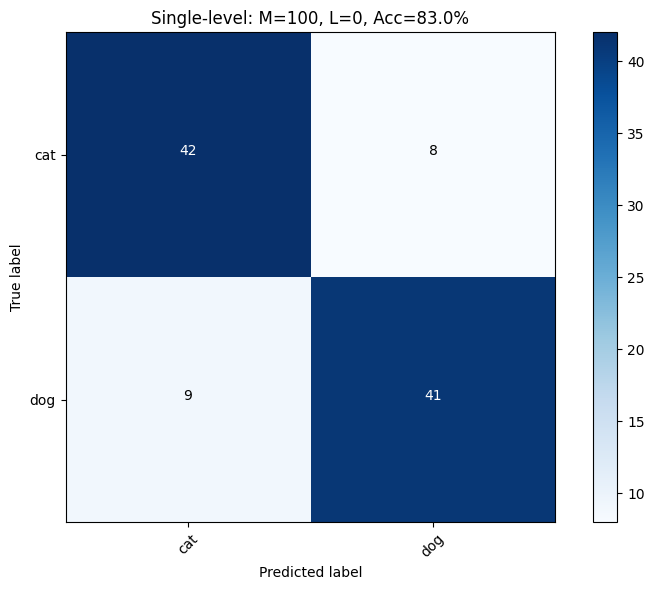

Single-level (L=0) Accuracy: 83.0%

===== Testing Vocabulary Size: 100, Level: 1 =====
Processing single-level features (L=1)...
Training SVM for single-level...


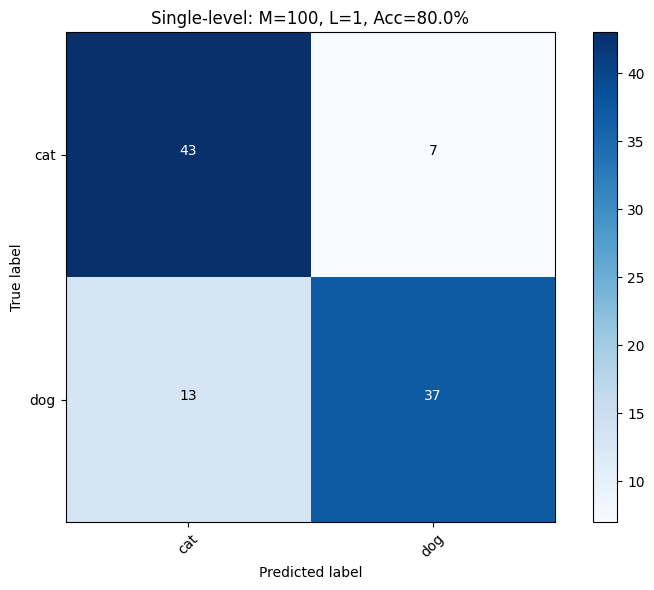

Single-level (L=1) Accuracy: 80.0%
Processing pyramid features (max_level=1)...
Training SVM for pyramid...


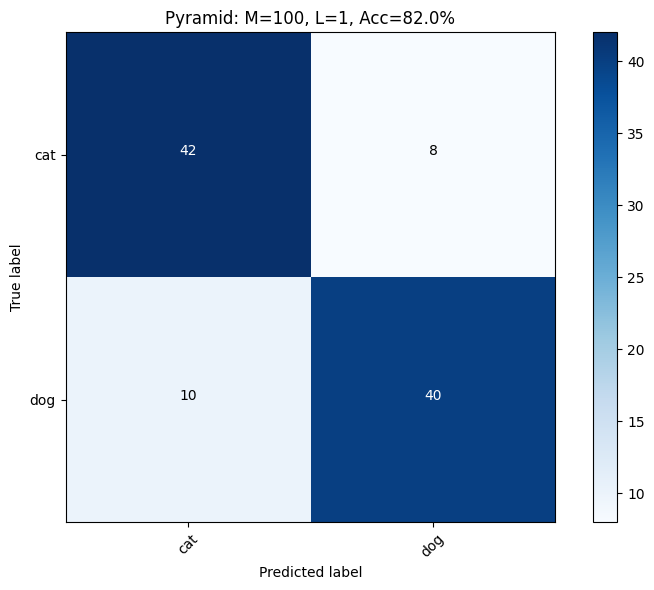

Pyramid (max_level=1) Accuracy: 82.0%

===== Testing Vocabulary Size: 100, Level: 2 =====
Processing single-level features (L=2)...
Training SVM for single-level...


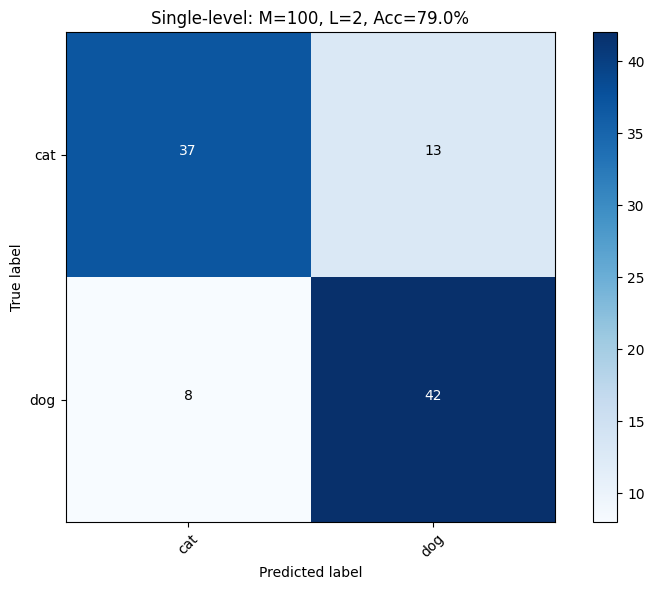

Single-level (L=2) Accuracy: 79.0%
Processing pyramid features (max_level=2)...
Training SVM for pyramid...


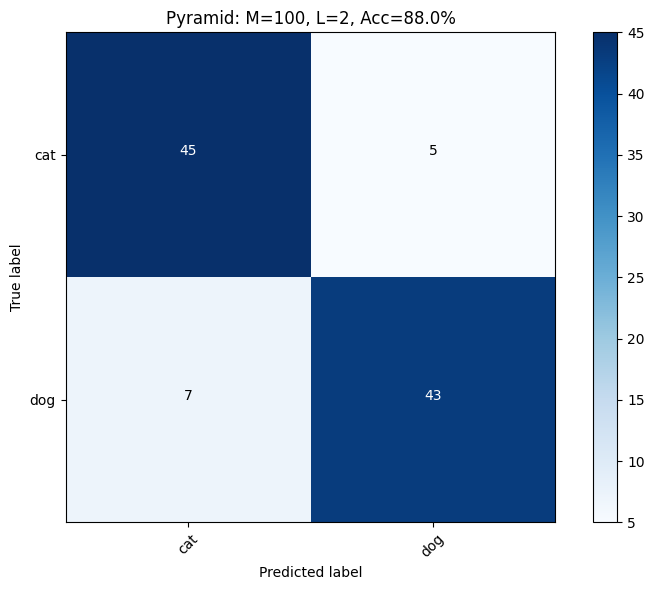

Pyramid (max_level=2) Accuracy: 88.0%

===== Testing Vocabulary Size: 100, Level: 3 =====
Processing single-level features (L=3)...
Training SVM for single-level...


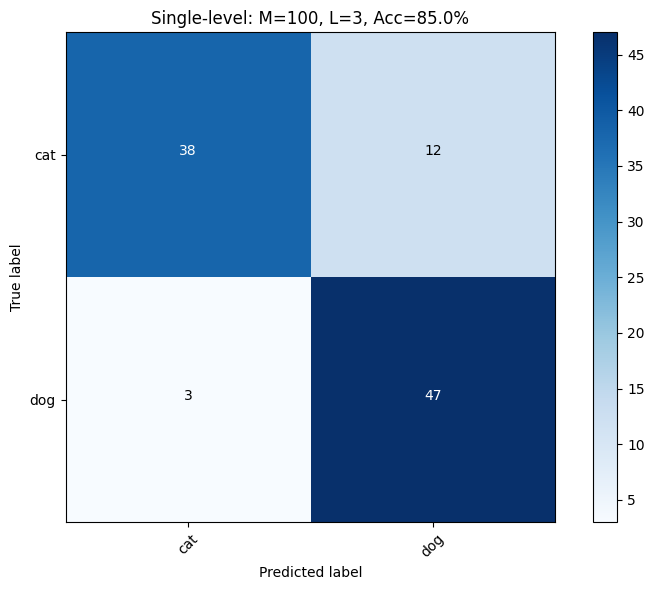

Single-level (L=3) Accuracy: 85.0%
Processing pyramid features (max_level=3)...
Training SVM for pyramid...


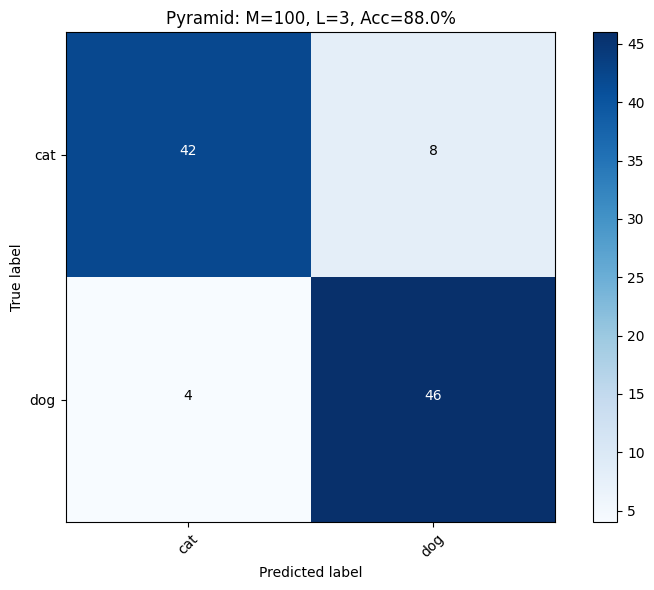

Pyramid (max_level=3) Accuracy: 88.0%


In [9]:
results, confusion_matrices = main()